In [141]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pylab
from pylab import *
import matplotlib.dates as mdate
from numpy import genfromtxt
import matplotlib.patches as patches
import os
import math

%matplotlib inline

In [142]:
def remove_outliers(arr):
    mean = np.mean(arr)
    sd = np.std(arr)
    final_list = [x for x in arr if (x > mean - 2 * sd)]
    final_list = [x for x in final_list if (x < mean + 2 * sd)]
    return final_list

def get_synopsis_stats(dir_name):
    files = os.listdir(dir_name)
    all_entries = []
    for f in files:
        f_path = dir_name + '/' + f
        f_entries = genfromtxt(f_path, delimiter=',')
        all_entries.append(f_entries[2:,1]/math.pow(10,6))
    latencies = remove_outliers(np.hstack(all_entries))
    return (np.median(latencies), 
            np.std(latencies), 
            np.percentile(latencies, 5),
            np.percentile(latencies, 25),
            np.percentile(latencies, 75),
            np.percentile(latencies, 95))

def get_sparksql_stats(f_name):
    latencies = genfromtxt(f_name, delimiter=',')
    return (np.median(latencies)*1000, #0
            np.std(latencies)*1000, #1
            np.percentile(latencies, 5)*1000, #2
            np.percentile(latencies, 25)*1000, #3
            np.percentile(latencies, 75)*1000, #4
            np.percentile(latencies, 95)*1000) #5

In [143]:
dirs = ['1_node', '2_node', '4_node', '8_node', '16_node']
stats = []
for d in dirs:
    stats.append(get_synopsis_stats('./spark-sql/synopsis/' + d))
syn_data = np.array(stats)

spark_sql_files = ['1', '2', '4', '8', '16']
spark_stats = []
for f in spark_sql_files:
    spark_stats.append(get_sparksql_stats('./spark-sql/spark-sql/spark-sql-' + f + '.csv'))
spark_data = np.array(spark_stats)

print(np.vstack([syn_data[:,0] - syn_data[:,2], syn_data[:,5] - syn_data[:,0]]))

[[ 0.2923557   0.2783375   0.9854635   2.5156151   2.847768  ]
 [ 1.5214897   2.75161815  3.8129349   3.3800902   3.311043  ]]


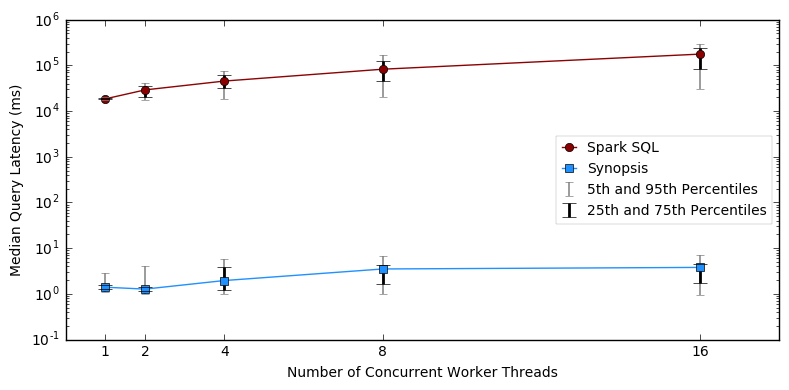

In [144]:
x_vals = [1, 2, 4, 8, 16]
fig,ax = plt.subplots(figsize=(8,4))
ax.set_yscale("log", nonposy='clip')
leg_spark = plt.errorbar(x_vals, spark_data[:,0], color='darkred', marker='o', lw=1, label='Spark SQL')
leg_r_q95 = ax.errorbar(x_vals, spark_data[:,0], yerr=np.vstack([spark_data[:,0] - spark_data[:,2], spark_data[:,5] - spark_data[:,0]]), 
                            label='5th and 95th Percentiles', ecolor='grey', color='white', lw=0.01, capsize=3, elinewidth=1.1)
leg_r_q75 = ax.errorbar(x_vals, spark_data[:,0], yerr=np.vstack([spark_data[:,0] - spark_data[:,3], spark_data[:,4] - spark_data[:,0]]), 
                            lw=0.0, label='25th and 75th Percentiles', ecolor='black', color='white', capsize=5, elinewidth=2.0)

leg_syn = plt.errorbar(x_vals, syn_data[:,0], color='dodgerblue', marker='s', lw=1 ,label='Synopsis')
leg_r_q95 = ax.errorbar(x_vals, syn_data[:,0], yerr=np.vstack([syn_data[:,0] - syn_data[:,2], syn_data[:,5] - syn_data[:,0]]), label='5th and 95th Percentiles', 
                       ecolor='grey', color='white', lw=0.01, capsize=3, elinewidth=1.1)
leg_r_q75 = ax.errorbar(x_vals, syn_data[:,0], yerr=np.vstack([syn_data[:,0] - syn_data[:,3], syn_data[:,4] - syn_data[:,0]]), lw=0.0, label='25th and 75th Percentiles', 
                       ecolor='black', color='white', capsize=5, elinewidth=2.0)


plt.xlabel('Number of Concurrent Worker Threads', fontsize=10)
plt.ylabel('Median Query Latency (ms)', fontsize=10)
plt.xlim(0, 18)
plt.xticks(x_vals)

lns = (leg_spark, leg_syn, leg_r_q95, leg_r_q75)
labs = [l.get_label() for l in lns]
leg = ax.legend(lns, labs, fontsize=10, ncol=1, loc='center right', borderaxespad=0.5, handlelength=1, numpoints=1)
#leg = ax3.legend(lns, labs, fontsize=9)
leg.get_frame().set_linewidth(0.1)
pylab.tight_layout()
plt.savefig('./spark-sql-query-complete.pdf', dpi=300, bbox_extra_artists=(leg,), bbox_inches='tight')